In [22]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from __future__ import division
import sys
import csv
csv.field_size_limit(sys.maxsize)

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import shapely.wkt
import shapely.affinity
import cv2

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
py.sign_in('junjchen', 'bdGkZpiRZ5nLdOCSD4o6') # Replace the username, and API key with your credentials.

class ImageFact:
    
    def __init__(self, img_id, labels):
        self.img_id = img_id
        self.labels = labels
        
        self.read_images()
        self.read_train_polygons()
        self.read_train_labels()
    
    def read_images(self):
        self.img_rgb = tiff.imread('input/%s.tif'%self.img_id).transpose((1, 2, 0))        
        self.img_p = tiff.imread('input/%s_P.tif'%self.img_id)
        (self.h, self.w, _) = self.img_rgb.shape
        
        img_a = tiff.imread('input/%s_A.tif'%self.img_id).transpose((1, 2, 0))
        img_m = tiff.imread('input/%s_M.tif'%self.img_id).transpose((1, 2, 0))
        self.img_a_full = self._upscale_image_to_full_size(img_a)
        self.img_m_full = self._upscale_image_to_full_size(img_m)
    
    def _upscale_image_to_full_size(self, img):
        (h, w, _) = img.shape
        img_full = scipy.ndimage.interpolation.zoom(img, (self.h / h, self.w / w, 1), order = 1)
        return img_full
    
    def read_train_polygons(self):
        self.train_polygons = {}
        
        for _im_id, _x, _y in csv.reader(open('../input/grid_sizes.csv')):
            if _im_id == self.img_id:
                x_max, y_min = float(_x), float(_y)
                break      
        x_scaler = self.w * (self.w / (self.w+1)) / x_max
        y_scaler = self.h * (self.h / (self.h+1)) / y_min   
        
        for _im_id, _poly_type, _poly in csv.reader(open('../input/train_wkt_v4.csv')):                
            if _im_id == self.img_id and _poly_type in self.labels:
                p = shapely.affinity.scale(shapely.wkt.loads(_poly), xfact = x_scaler, yfact = y_scaler, origin = (0,0,0)) 
                self.train_polygons[_poly_type] = p

    def read_train_labels(self):
        self.img_labels = {}
        for k in self.train_polygons:
            train_polygon = self.train_polygons[k]
            img_label = np.zeros((self.h, self.w), np.uint8)
            int_coords = lambda x: np.array(x).round().astype(np.int32)
            exteriors = [int_coords(poly.exterior.coords) for poly in train_polygon]
            interiors = [int_coords(pi.coords) for poly in train_polygon
                         for pi in poly.interiors]
            cv2.fillPoly(img_label, exteriors, 1)
            cv2.fillPoly(img_label, interiors, 0)
            self.img_labels[k] = img_label
        
        self.combined_labels = np.zeros((self.h, self.w), np.uint8)
        for k in self.img_labels:
            self.combined_labels = np.bitwise_or(self.combined_labels, self.img_labels[k])
            

In [3]:
i = ImageFact('6070_2_3', ['7', '8'])

In [4]:
# Split train and test groups

# reduced training samples size
tr_img_m_bands = np.dstack((i.img_m_full[2000:3000], i.combined_labels[2000:3000]))
#ts_img_m_bands = np.dstack((i.img_m_full[1500:3350], i.combined_labels[1500:3350]))

tr_water_dn = tr_img_m_bands[1 == tr_img_m_bands[:,:,8]]
tr_non_water_dn = tr_img_m_bands[0 == tr_img_m_bands[:,:,8]]

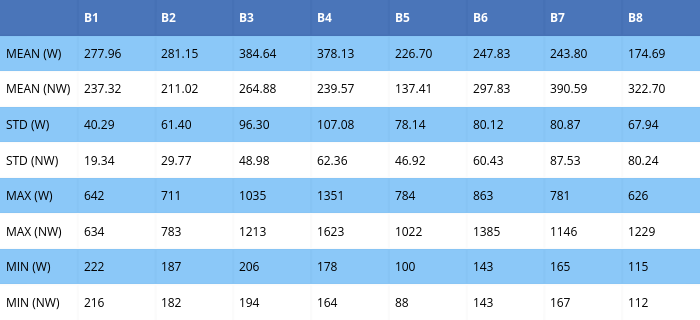

In [27]:
# Plot table on dn stats for the 8 band

def gen_dn_statics_for_table(dns):    
    dn_mean = np.mean(dns, axis = 0)
    dn_std = np.std(dns, axis = 0)
    dn_max = np.max(dns, axis = 0)
    dn_min = np.min(dns, axis = 0)    
    dn_mean_formatted = ['%1.2f'%dn for dn in dn_mean]
    dn_std_formatted = ['%1.2f'%dn for dn in dn_std]
    dn_max_formatted = ['%d'%dn for dn in dn_max]
    dn_min_formatted = ['%d'%dn for dn in dn_min]    
    return (dn_mean_formatted, dn_std_formatted, dn_max_formatted, dn_min_formatted, dn_mean, dn_std, dn_max, dn_min)
    
water_dn_mean_formatted, water_dn_std_formatted, water_dn_max_formatted, water_dn_min_formatted, _, _, _, _ = gen_dn_statics_for_table(tr_water_dn[:,0:8])
water_dn_mean_formatted.insert(0, 'MEAN (W)')
water_dn_std_formatted.insert(0, 'STD (W)')
water_dn_max_formatted.insert(0, 'MAX (W)')
water_dn_min_formatted.insert(0, 'MIN (W)')

non_water_dn_mean_formatted, non_water_dn_std_formatted, non_water_dn_max_formatted, non_water_dn_min_formatted, _, _, _, _ = gen_dn_statics_for_table(tr_non_water_dn[:,0:8])
non_water_dn_mean_formatted.insert(0, 'MEAN (NW)')
non_water_dn_std_formatted.insert(0, 'STD (NW)')
non_water_dn_max_formatted.insert(0, 'MAX (NW)')
non_water_dn_min_formatted.insert(0, 'MIN (NW)')

colorscale = [[0, '#0D47A1'],[.5, '#64B5F6'],[1, '#ffffff']]
table = ff.create_table([
    ['', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'],
    water_dn_mean_formatted,
    non_water_dn_mean_formatted,    
    water_dn_std_formatted,
    non_water_dn_std_formatted,    
    water_dn_max_formatted,
    non_water_dn_max_formatted,    
    water_dn_min_formatted,        
    non_water_dn_min_formatted
], colorscale=colorscale)

py.image.ishow(table)

In [84]:
# plot dn histogram for band

def plot_histogram_for_band(b,i = False):    
    data = [
        go.Histogram(x=tr_water_dn[:,b-1], opacity=0.75, name='water'),
        go.Histogram(x=tr_non_water_dn[:,b-1], opacity=0.75, name='not-water')
    ]
    layout = go.Layout(barmode='overlay', title='Histogram for band ' + str(b))
    fig = go.Figure(data=data, layout=layout)

    if i:
        py.iplot(fig, filename='')
    else:
        py.image.ishow(fig)

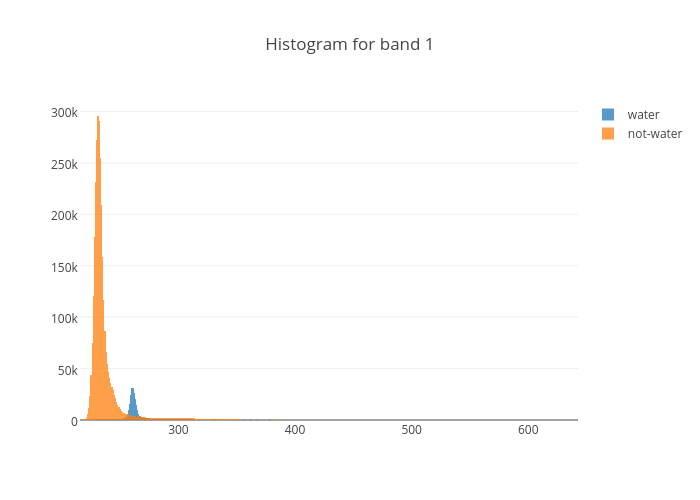

In [53]:
# band 1
plot_histogram_for_band(1)
# interactive plot at https://plot.ly/~junjchen/0/histogram-for-band-1/

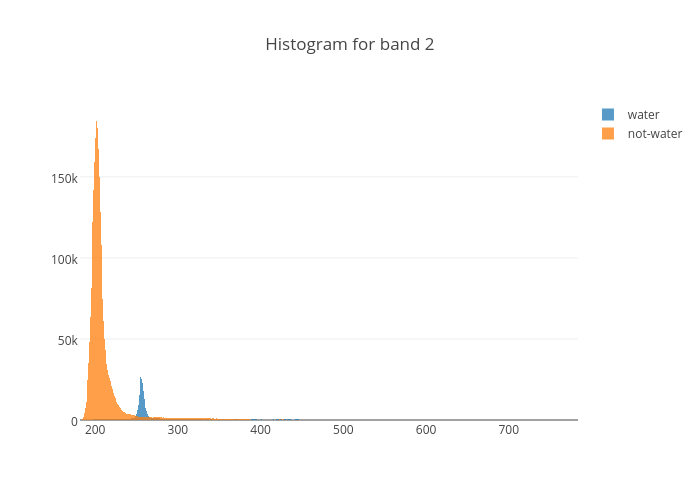

In [55]:
# band 2
plot_histogram_for_band(2)
# interactive plot at https://plot.ly/~junjchen/0/histogram-for-band-2/

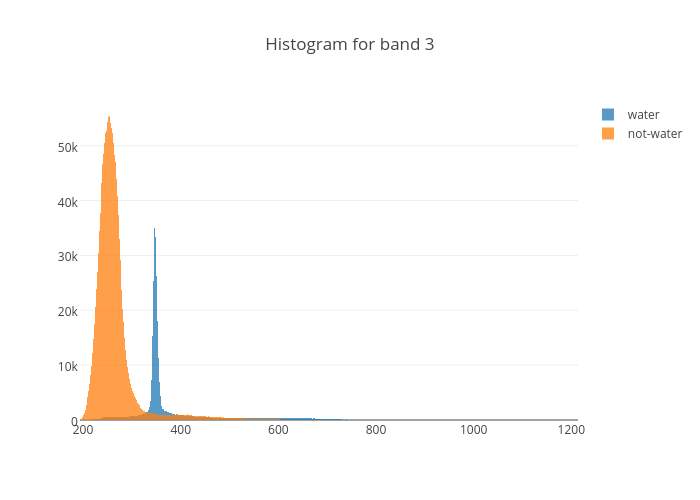

In [56]:
# band 3
plot_histogram_for_band(3)

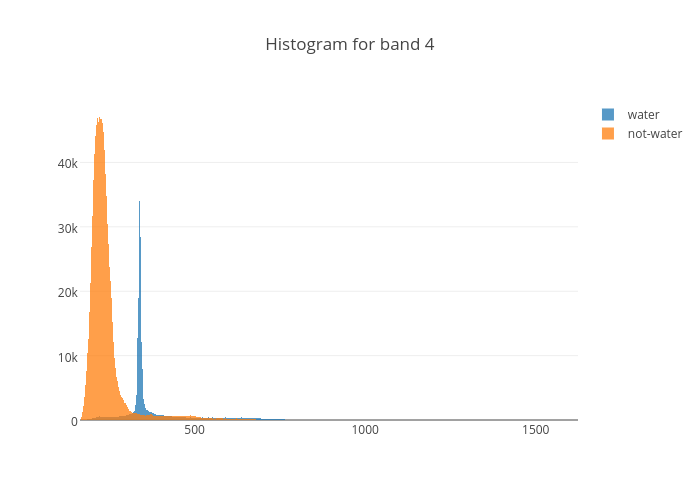

In [57]:
# band 4
plot_histogram_for_band(4)

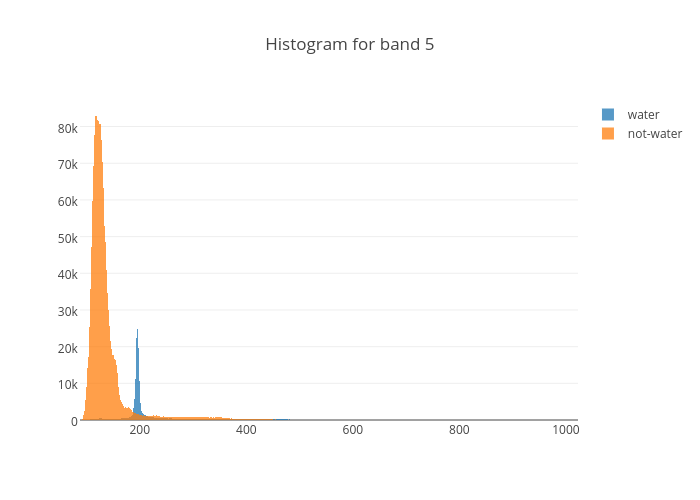

In [58]:
# band 5
plot_histogram_for_band(5)

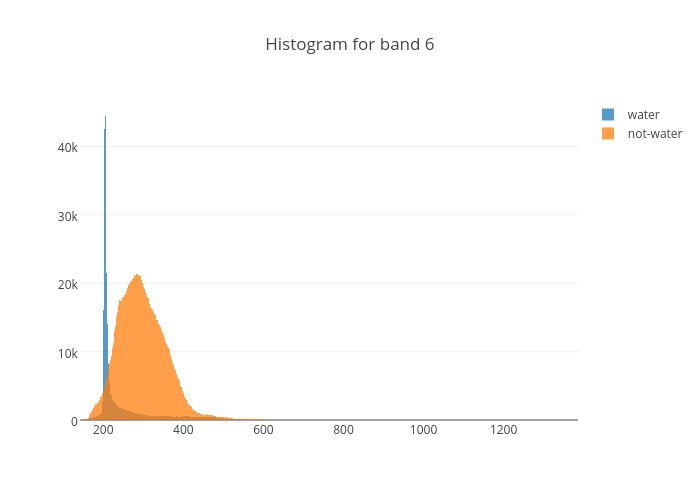

In [59]:
# band 6
plot_histogram_for_band(6)

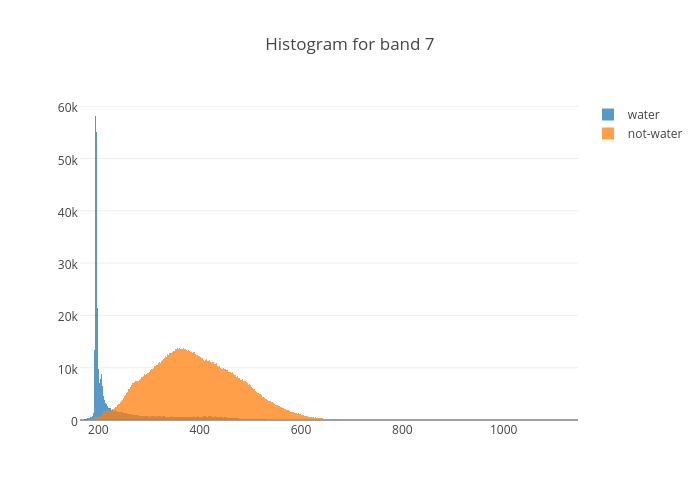

In [60]:
# band 7
plot_histogram_for_band(7)
# interactive plot at https://plot.ly/~junjchen/0/histogram-for-band-7/

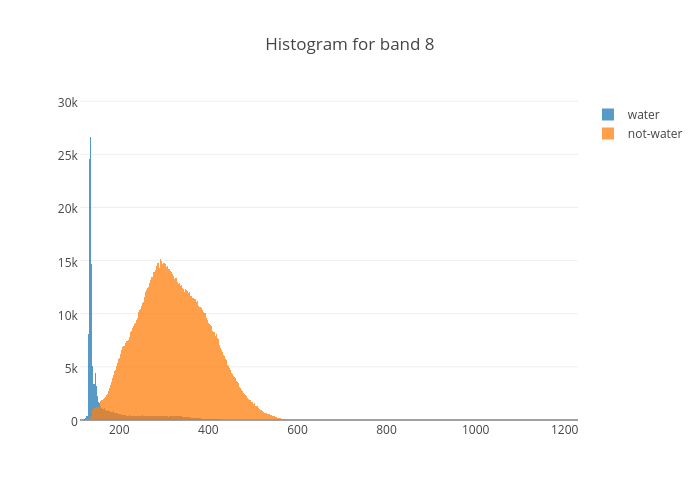

In [54]:
# band 8
plot_histogram_for_band(8)
# interactive plot at https://plot.ly/~junjchen/0/histogram-for-band-8/

In [86]:
plot_histogram_for_band(7, True)

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~junjchen/0 or inside your plot.ly account where it is named 'plot from API'


In [133]:
# Band 3, 4, 5, 6 not fit for classification, use band 1, 2, 7, 8 for density slicing
def density_slicing(band, lower_limit, upper_limit):
    tp = tn = fp = fn = 0
    band_data = tr_img_m_bands[:, :, [band-1, 8]].reshape(-1, 2)
    for d in band_data:
        dn = d[0]
        lb = d[1]
        if lower_limit <= dn and upper_limit >= dn:
            if lb == 1:
                tp += 1
            else:
                fp += 1
        else:
            if lb == 0:
                tn += 1
            else:
                fn += 1
            
    return tp, tn, fp, fn


b1_tp, b1_tn, b1_fp, b1_fn = density_slicing(1, 256, 267)
b2_tp, b2_tn, b2_fp, b2_fn = density_slicing(2, 249, 265)
b7_tp, b7_tn, b7_fp, b7_fn = density_slicing(7, 165, 225)
b8_tp, b8_tn, b8_fp, b8_fn = density_slicing(8, 115, 156)


In [121]:
def analyze_result(tp, tn, fp, fn):
    table = ff.create_table([
        ['', 'WATER (PREDICT)', 'NOT_WATER (PREDICT)', 'ACC'],
        ['WATER (TRUTH)', tp, fn, '%.2f%%'%(100 * tp / (tp + fn))],
        ['NOT_WATER (TRUTH)', fp, tn, '%.2f%%'%(100 * tn / (fp + tn))],
        ['REL', '%.2f%%'%(100 * tp / (tp + fp)), '%.2f%%'%(100 * tn / (fn + tn))]
    ], index_title='asdasd')
    py.image.ishow(table)
    print('Average accuracy: ' + '%.2f%%'%(100 * (tp / (tp + fn) + tn / (fp + tn)) / 2))
    print('Average reliability: ' + '%.2f%%'%(100 * (tp / (tp + fp) + tn / (fn + tn)) / 2))
    print('Overall accuracy: ' + '%.2f%%'%(100 * (tp + tn) / (tp + tn + fp + fn)))

==> RESULT ON BAND 1:


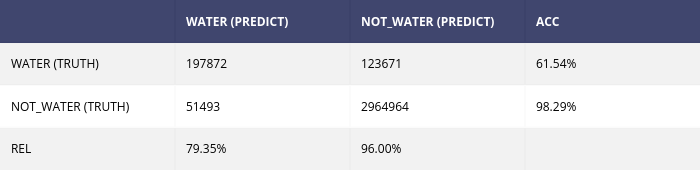

Average accuracy: 79.92%
Average reliability: 87.67%
Overall accuracy: 94.75%


In [134]:
print('==> RESULT ON BAND 1:')
analyze_result(b1_tp, b1_tn, b1_fp, b1_fn)
# questionable on the ability on generalization

==> RESULT ON BAND 2:


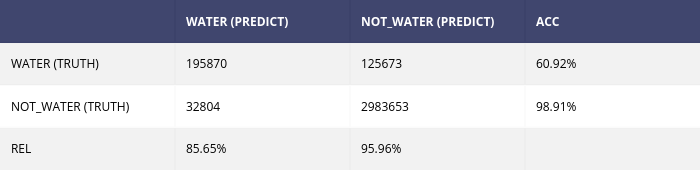

Average accuracy: 79.91%
Average reliability: 90.81%
Overall accuracy: 95.25%


In [135]:
print('==> RESULT ON BAND 2:')
analyze_result(b2_tp, b2_tn, b2_fp, b2_fn)

==> RESULT ON BAND 7:


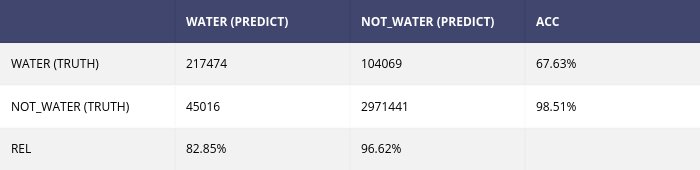

Average accuracy: 83.07%
Average reliability: 89.73%
Overall accuracy: 95.53%


In [137]:
print('==> RESULT ON BAND 7:')
analyze_result(b7_tp, b7_tn, b7_fp, b7_fn)
# Turbid water is indistinguishable from this band (long tail of the histogram), those are mis-classified as NW.

==> RESULT ON BAND 8:


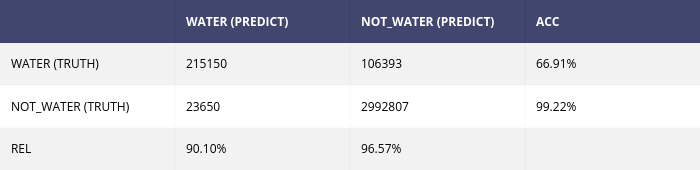

Average accuracy: 83.06%
Average reliability: 93.33%
Overall accuracy: 96.10%


In [138]:
print('==> RESULT ON BAND 8:')
analyze_result(b8_tp, b8_tn, b8_fp, b8_fn)